# Распознавание речи. Семинар 1.

## План занятия:
* Познакомимся с методами торча для работы со звуком
* Имплементируем расчет метрик (WER, CER)
* Посмотрим, как можно аугментировать звук (https://arxiv.org/abs/1904.08779)
* Обсудим домашнее задание

In [7]:
!pip install python-Levenshtein > /dev/null

In [8]:
import math
import os
import string

from typing import List

import Levenshtein
import librosa
import numpy as np
import torch
import torch.nn.functional as F
import torchaudio

from IPython import display
from matplotlib import pyplot as plt
from torch import distributions
from torch import nn
import random


# Метрики ASR
## WER (Word Error Rate)
WER измеряет различие между GT транскрипцией и предсказанной гипотезой на уровне слов. Этот показатель рассчитывается как минимальное количество вставок (I), удалений (D) и замен (S), необходимых для преобразования полученной гипотезы в GT транскрибцию, делённое на общее количество слов в GT транскрипции.
$$WER = \frac{I + D + S}{N},\ N - длина \ GT\ предложения$$

## CER (Character Error Rate)
CER аналогично WER, измеряет количество ошибок, но на уровне символов. Считается аналогично, только для символов последовательности.
$$CER = \frac{I + D + S}{N},\ N - длина \ GT\ слова$$








[Алгоримт Левенштейна](https://neerc.ifmo.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BE_%D1%80%D0%B5%D0%B4%D0%B0%D0%BA%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%BE%D0%BC_%D1%80%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B8,_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%92%D0%B0%D0%B3%D0%BD%D0%B5%D1%80%D0%B0-%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)
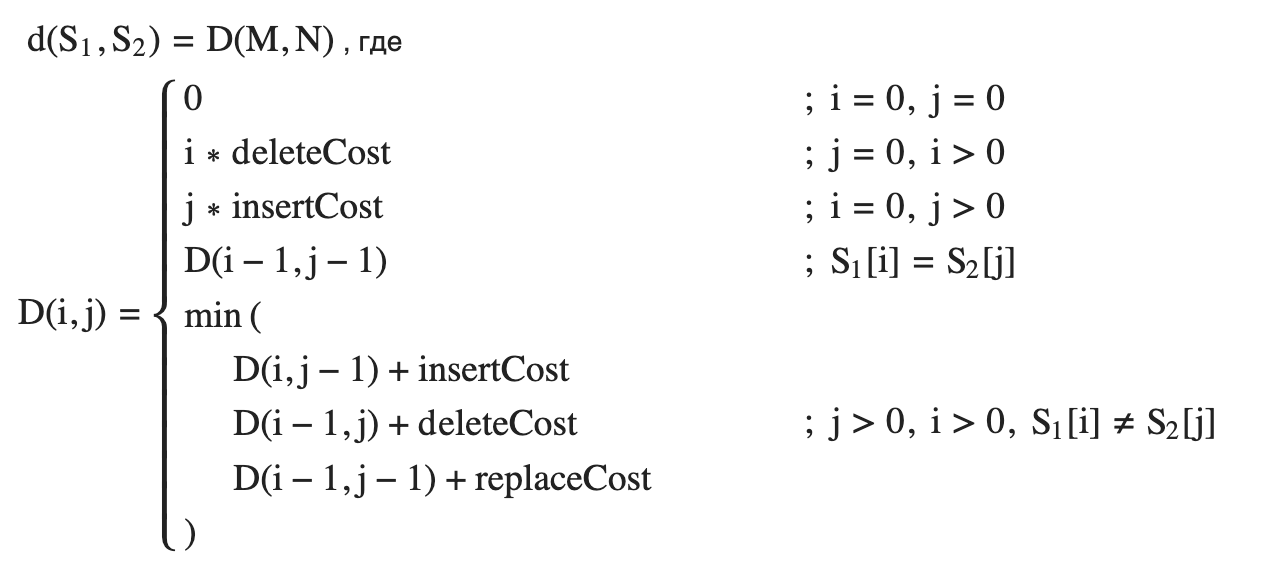

In [9]:
def calculate_wer(reference, hypothesis):
    """Calculates the Word Error Rate (WER).

    WER measures the difference between the reference transcript and the output
    transcript in terms of words. It is calculated as the minimum number of
    insertions, deletions, and substitutions required to transform the output
    into the reference, divided by the total number of words in the reference.

    Args:
    reference: The reference transcript.
    hypothesis: The output transcript.

    Returns:
    The WER as a float.
    """
    # YOUR CODE

    return wer

In [ ]:
assert calculate_wer('hello world', 'hello world') == 0.0
assert calculate_wer('hello world', 'hello') == 1 / 2
assert calculate_wer('hello world', '') == 1.0
assert calculate_wer('hello world', 'hello hello hello hello') == 3 / 2

In [ ]:
Levenshtein.distance('hello world', 'hello', processor=lambda x: x.split()) / len('hello world'.split())

0.5

In [ ]:
def calculate_cer(reference, hypothesis):
    """Calculates the Character Error Rate (CER).

    CER, similar to WER, measures the error rate but at the character level.
    It calculates the minimum number of insertions, deletions, and substitutions
    required to transform the output into the reference, divided by the total
    number of characters in the reference.

    Args:
    reference: The reference transcript.
    hypothesis: The output transcript.

    Returns:
    The CER as a float.
    """
    # YOUR CODE

    return cer

In [ ]:
assert calculate_cer('hello', 'hello') == 0.0
assert calculate_cer('hello', 'hell') == 1 / 5
assert calculate_cer('hello', 'he') == 3 / 5
assert calculate_cer('hello', 'h') == 4 / 5
assert calculate_cer('hello', '') == 1.0
assert calculate_cer('hello', 'hhhhelloooo') == 6 / 5

In [ ]:
Levenshtein.distance('hello', 'hhhhelloooo') / len('hello')

1.2

# Аугментации входных данных

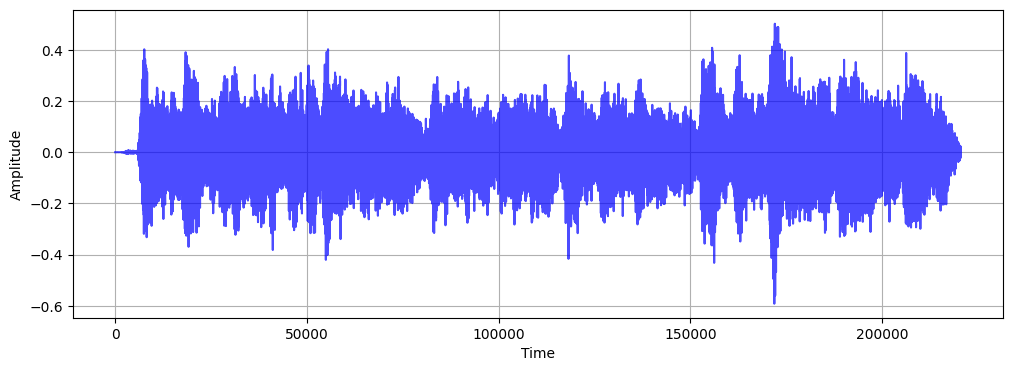

In [10]:
def visualize_audio(wav: torch.Tensor, sr: int = 16000):
    plt.figure(figsize=(12, 4))
    plt.plot(wav, alpha=.7, c='blue')
    plt.grid()
    plt.xlabel('Time', size=10)
    plt.ylabel('Amplitude', size=10)
    plt.show()
    display.display(display.Audio(wav, rate=sr, normalize=False))

wav, sr = librosa.load(librosa.ex('brahms'), duration=10)
wav = torch.from_numpy(wav)
if wav.dim() == 2:
    wav = wav.mean(dim=0)
visualize_audio(wav, sr)

## Добавим Гауссовского шума

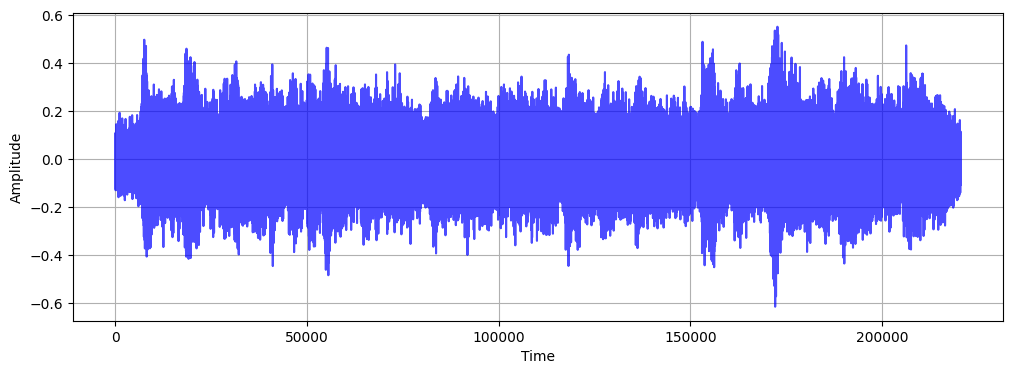

In [ ]:
noise = distributions.Normal(0, 0.05)
augumented_wav = wav + noise.sample(wav.size())
visualize_audio(augumented_wav, sr)

## Сожмем временную размерность

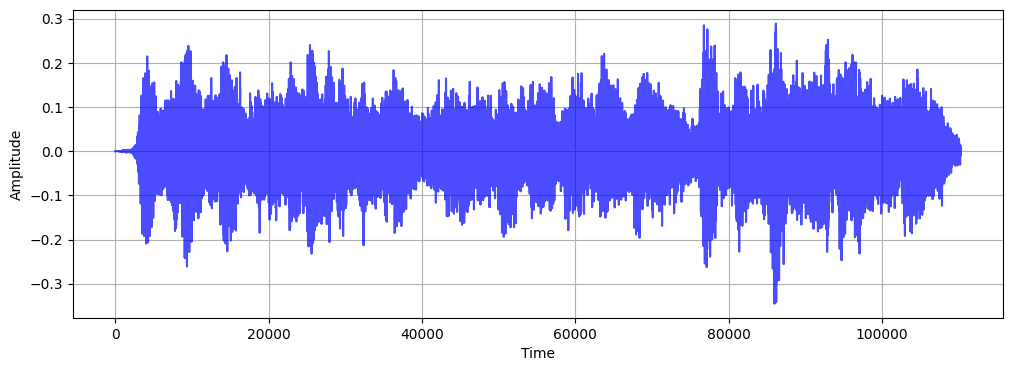

In [ ]:
augumented_wav = librosa.effects.time_stretch(wav.numpy().squeeze(), rate=2.0)
augumented_wav = torch.from_numpy(augumented_wav)
visualize_audio(augumented_wav, sr)

## Повысим частоту

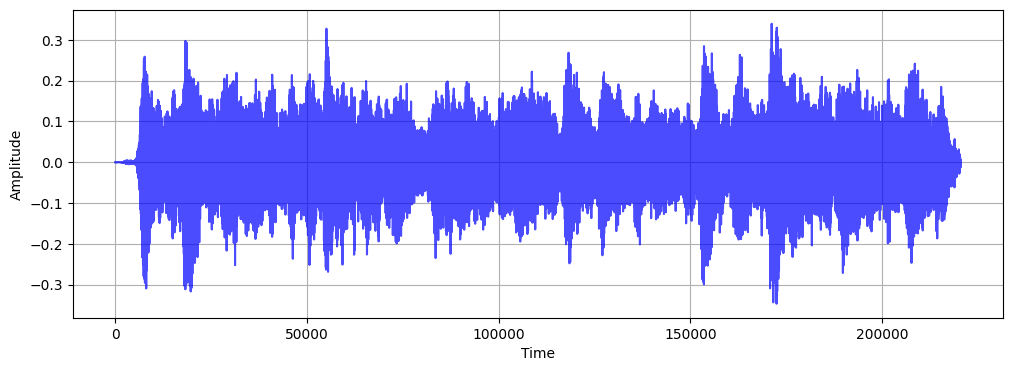

In [ ]:
augumented_wav = librosa.effects.pitch_shift(wav.numpy().squeeze(), sr=sr, n_steps=5)
augumented_wav = torch.from_numpy(augumented_wav)
visualize_audio(augumented_wav, sr)

## Увеличим громкость

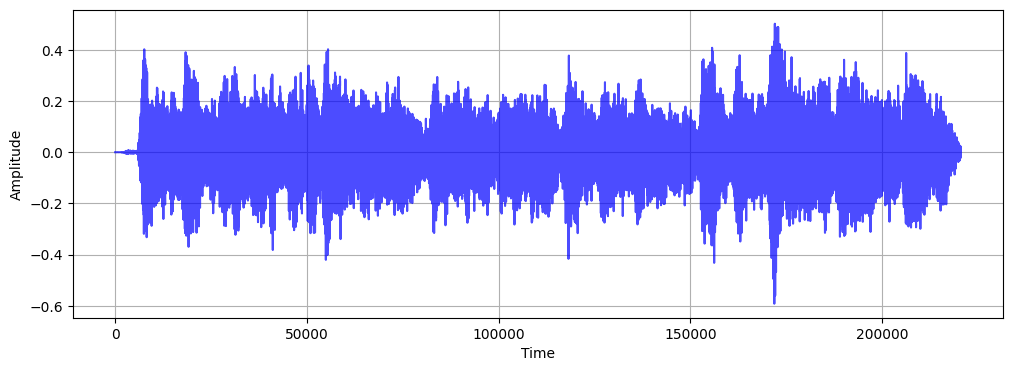

In [ ]:
voler = torchaudio.transforms.Vol(gain=1.0, gain_type='amplitude')
augumented_wav = voler(wav)
visualize_audio(augumented_wav, sr)

## Добавим фонового шума

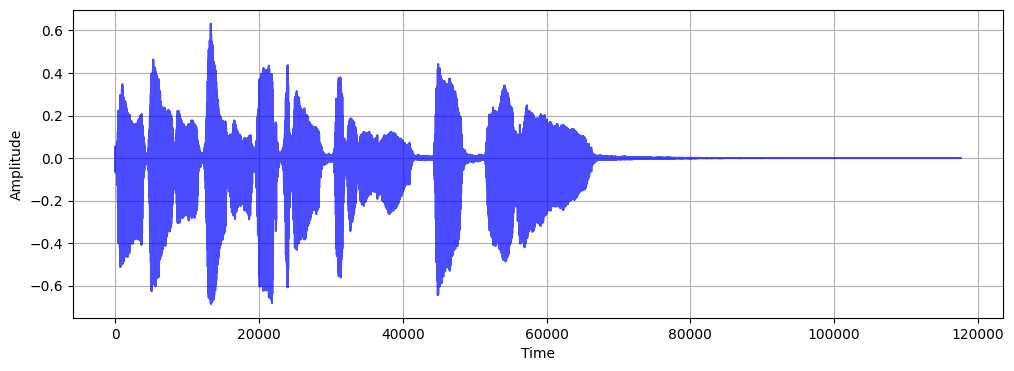

In [ ]:
filename = librosa.ex('trumpet')
noise, _ = librosa.load(filename, sr=sr)
visualize_audio(torch.from_numpy(noise), sr)

Recap: энергия дискретного сигнала 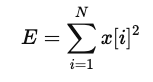

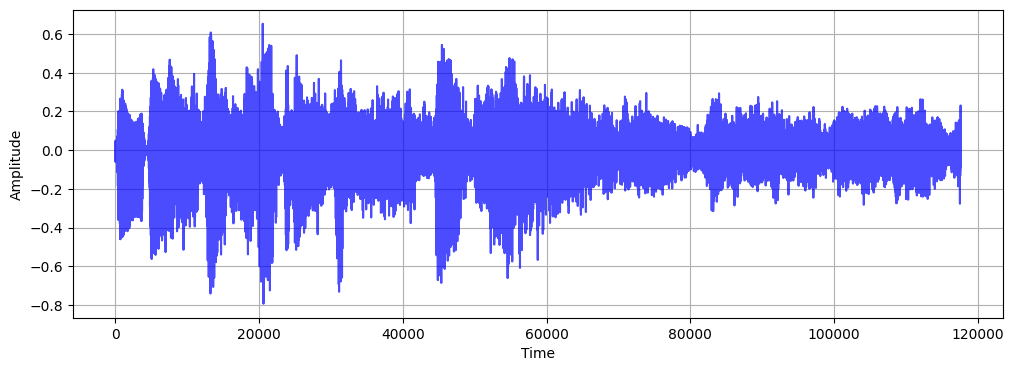

In [ ]:
noise_level = torch.Tensor([5])

noise_energy = torch.norm(torch.from_numpy(noise))
audio_energy = torch.norm(wav)

alpha = (audio_energy / noise_energy) * torch.pow(10, -noise_level / 20)

clipped_wav = wav[..., :noise.shape[0]]

augumented_wav = clipped_wav + alpha * torch.from_numpy(noise)
augumented_wav = torch.clamp(augumented_wav, -1, 1)

visualize_audio(augumented_wav, sr)

# SpecAugment


In [1]:
def spec_augment_masking(spectrogram, frequency_masking_factor, time_masking_factor):
    """SpecAugment involves three types of augmentations: time warping, frequency
    masking, and time masking. Frequency masking and time masking involve masking random sections
    of the spectrogram in the frequency and time domains, respectively.
    Time warping is not implemented.

    Args:
    spectrogram: The spectrogram to augment.
    frequency_masking_factor: The factor by which to mask the spectrogram in the
        frequency domain.
    time_masking_factor: The factor by which to mask the spectrogram in the
        time domain.

    Returns:
    The augmented spectrogram.
    """
    # Spec [* x num_mels x num_frames]
    # Frequency masking
    # YOUR CODE

    # Time masking
    # YOUR CODE

    return spec

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


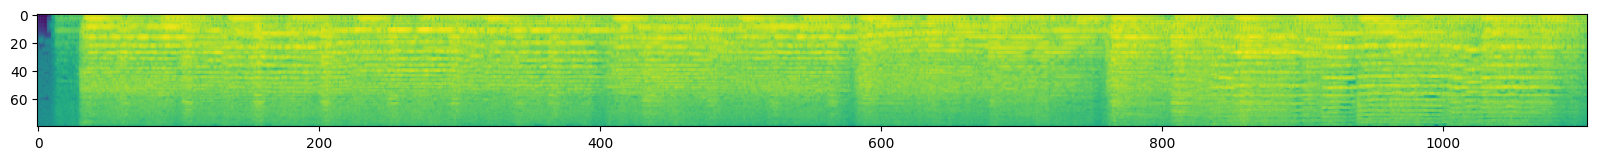

In [11]:
mel_spectrogramer = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=400,
    win_length=400,
    hop_length=200,
    n_mels=80,
)

mel_spectrogram = mel_spectrogramer(wav)
log_mel_spectrogram = torch.log(mel_spectrogram).squeeze()
plt.figure(figsize=(20, 8))
plt.imshow(log_mel_spectrogram)
plt.show()

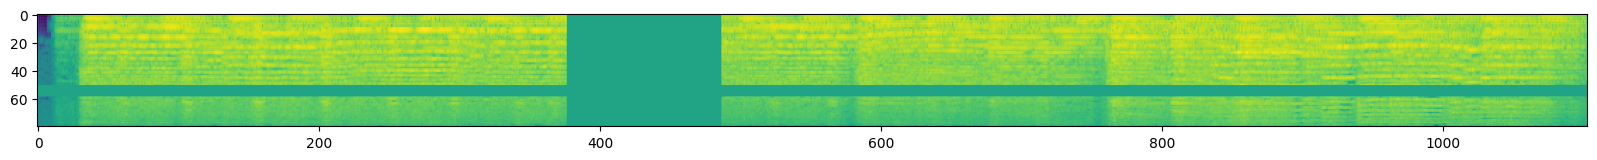

In [15]:
augumented_mel_spectrogram = spec_augment_masking(mel_spectrogram, 0.1, 0.1)
augumented_log_mel_spectrogram = torch.log(augumented_mel_spectrogram).squeeze()
plt.figure(figsize=(20, 8))
plt.imshow(augumented_log_mel_spectrogram)
plt.show()